In [3]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM, MaxPooling1D,BatchNormalization,GRU, SpatialDropout1D
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [5]:
data = pd.read_csv('Top30.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72292 entries, 0 to 72291
Data columns (total 4 columns):
Unnamed: 0      72292 non-null int64
Unnamed: 0.1    72292 non-null int64
Query           72292 non-null object
Description     72292 non-null object
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [7]:
data.Query.value_counts()

Administrative Assistant                                      4395
Customer Service Representative                               4200
Own Your Own Franchise!                                       3701
Sales Representative                                          3556
Mobile Tool Sales / Franchise Distributor                     3275
Retail Wireless Sales Consultant                              3194
Sales / Franchise                                             3120
Project Manager                                               2845
Staff Accountant                                              2834
Retail Sales Associate                                        2769
Business Analyst                                              2420
Sales / Customer Service – Part or Full time – Summer Work    2419
Sales Representative / Account Manager /  Customer Service    2412
Senior Accountant                                             2216
Jani-King Franchise Business Opportunity                      

In [8]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Description'] = data['Description'].apply(clean_text)
data['Query'] = data['Query'].apply(clean_text)

In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 167446 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(data['Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (72292, 250)


In [11]:
Y = pd.get_dummies(data['Query']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (72292, 30)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(65062, 250) (65062, 30)
(7230, 250) (7230, 30)


In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(30, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 5,063,330
Trainable params: 5,063,330
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 58555 samples, validate on 6507 samples
Epoch 1/5
58555/58555 [==============================] - 310s 5ms/step - loss: 1.0647 - acc: 0.6888 - val_loss: 0.3514 - val_acc: 0.8895
Epoch 2/5
58555/58555 [==============================] - 290s 5ms/step - loss: 0.2765 - acc: 0.9133 - val_loss: 0.2023 - val_acc: 0.9344
Epoch 3/5
58555/58555 [==============================] - 289s 5ms/step - loss: 0.1632 - acc: 0.9465 - val_loss: 0.1786 - val_acc: 0.9419
Epoch 4/5
58555/58555 [==============================] - 295s 5ms/step - loss: 0.1173 - acc: 0.9607 - val_loss: 0.1820 - val_acc: 0.9391
Epoch 5/5
58555/58555 [==============================] - 292s 5ms/step - loss: 0.0882 - acc: 0.9690 - val_loss: 0.1873 - val_acc: 0.9414


In [15]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7230/7230 [==============================] - 26s 4ms/step
Test set
  Loss: 0.158
  Accuracy: 0.950


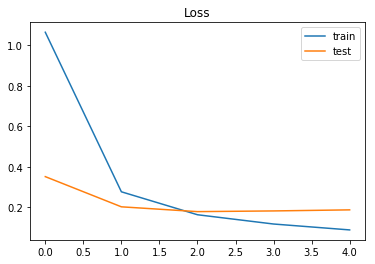

In [16]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

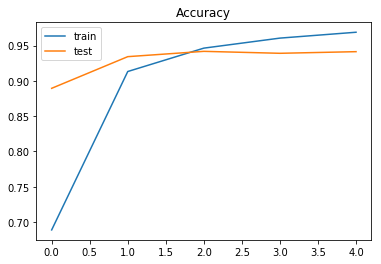

In [17]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();